In [1]:
import os
import sys

# Allow imports from src folder
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import betfairlightweight
from betfairlightweight import filters
from datetime import datetime, timedelta
from dateutil import tz
from pandas.tseries.offsets import MonthEnd
import itertools

import math
import numpy as np
import pandas as pd
import fasttrack as ft

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from matplotlib import pyplot
from matplotlib.pyplot import figure

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Validate FastTrack API connection
client = ft.Fasttrack(os.getenv('FAST_TRACK_API_KEY'))
track_codes = client.listTracks()

Valid Security Key


In [3]:
# Import AU races data
au_tracks_filter = list(track_codes[track_codes['state'] != 'NZ']['track_code'])

race_details = pd.DataFrame()
dog_results = pd.DataFrame()

# For each month of data, either use local CSV file or fetch from API
for start in pd.date_range('2017-12-01', '2021-07-31', freq='MS'):
    start_date = start.strftime("%Y-%m-%d")
    end_date = (start + MonthEnd(1)).strftime("%Y-%m-%d")
    filename_races = f'FT_AU_RACES_{start_date}.csv'
    filename_dogs = f'FT_AU_DOGS_{start_date}.csv'
    
    filepath_races = f'../data/{filename_races}'
    filepath_dogs = f'../data/{filename_dogs}'
    
    print(f'Loading data from {start_date} to {end_date}')
    if os.path.isfile(filepath_races):
        # Load local CSV file
        month_race_details = pd.read_csv(filepath_races) 
        month_dog_results = pd.read_csv(filepath_dogs) 
    else:
        # Fetch data from API
        month_race_details, month_dog_results = client.getRaceResults(start_date, end_date, au_tracks_filter)
        month_race_details.to_csv(filepath_races, index=False)
        month_dog_results.to_csv(filepath_dogs, index=False)

    # Combine monthly data
    race_details = race_details.append(month_race_details, ignore_index=True)
    dog_results = dog_results.append(month_dog_results, ignore_index=True)

Loading data from 2017-12-01 to 2017-12-31
Loading data from 2018-01-01 to 2018-01-31
Loading data from 2018-02-01 to 2018-02-28
Loading data from 2018-03-01 to 2018-03-31
Loading data from 2018-04-01 to 2018-04-30
Loading data from 2018-05-01 to 2018-05-31


/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from 2018-06-01 to 2018-06-30
Loading data from 2018-07-01 to 2018-07-31
Loading data from 2018-08-01 to 2018-08-31
Loading data from 2018-09-01 to 2018-09-30
Loading data from 2018-10-01 to 2018-10-31
Loading data from 2018-11-01 to 2018-11-30
Loading data from 2018-12-01 to 2018-12-31
Loading data from 2019-01-01 to 2019-01-31
Loading data from 2019-02-01 to 2019-02-28
Loading data from 2019-03-01 to 2019-03-31
Loading data from 2019-04-01 to 2019-04-30
Loading data from 2019-05-01 to 2019-05-31
Loading data from 2019-06-01 to 2019-06-30
Loading data from 2019-07-01 to 2019-07-31
Loading data from 2019-08-01 to 2019-08-31
Loading data from 2019-09-01 to 2019-09-30
Loading data from 2019-10-01 to 2019-10-31
Loading data from 2019-11-01 to 2019-11-30
Loading data from 2019-12-01 to 2019-12-31
Loading data from 2020-01-01 to 2020-01-31
Loading data from 2020-02-01 to 2020-02-29
Loading data from 2020-03-01 to 2020-03-31
Loading data from 2020-04-01 to 2020-04-30
Loading dat

/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from 2021-06-01 to 2021-06-30
Loading data from 2021-07-01 to 2021-07-31


In [4]:
# Clean up the race dataset
race_details = race_details.rename(columns = {'@id': 'FastTrack_RaceId'})
race_details['Distance'] = race_details['Distance'].apply(lambda x: int(x.replace("m", "")))
race_details['date_dt'] = pd.to_datetime(race_details['date'], format = '%d %b %y')

# Clean up the dogs results dataset
dog_results = dog_results.rename(columns = {'@id': 'FastTrack_DogId', 'RaceId': 'FastTrack_RaceId'})
# Add race attributes
dog_results = dog_results.merge(
    race_details[['FastTrack_RaceId', 'Distance', 'RaceGrade', 'Track', 'date_dt']], 
    how = 'left',
    on = 'FastTrack_RaceId'
)
# Convert StartPrice to probability
dog_results['StartPrice'] = dog_results['StartPrice'].apply(lambda x: None if x is None else float(x.replace('$', '').replace('F', '')) if isinstance(x, str) else x)
dog_results['StartPrice_probability'] = (1 / dog_results['StartPrice']).fillna(0)
dog_results['StartPrice_probability'] = dog_results.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x / x.sum())
# Discard entries with no results as not racing (scratched)
dog_results = dog_results[~dog_results['Box'].isnull()]
dog_results['Box'] = dog_results['Box'].astype(int)
# Clean up other attributes
dog_results['RunTime'] = dog_results['RunTime'].astype(float)
dog_results['SplitMargin'] = dog_results['SplitMargin'].astype(float)
dog_results['Prizemoney'] = dog_results['Prizemoney'].astype(float).fillna(0)
dog_results['Prizemoney_norm'] = np.log10(dog_results['Prizemoney'] + 1) / 12
dog_results['Place'] = pd.to_numeric(dog_results['Place'].apply(lambda x: x.replace("=", "") if isinstance(x, str) else 0), errors='coerce').fillna(0)
dog_results['Place_inv'] = (1 / dog_results['Place']).fillna(0)
dog_results['Place_log'] = np.log10(dog_results['Place'] + 1).fillna(0)
dog_results['win'] = dog_results['Place'].apply(lambda x: 1 if x == 1 else 0)
dog_results['RunSpeed'] = (dog_results['RunTime'] / dog_results['Distance']).fillna(0)
dog_results['RunSpeed_norm'] = MinMaxScaler().fit_transform(dog_results[['RunTime']])

In [5]:
# Calculate median winner time per track/distance
win_results = dog_results[dog_results['win'] == 1]
median_win_time = pd.DataFrame(data=win_results[win_results['RunTime'] > 0].groupby(['Track', 'Distance'])['RunTime'].median()).rename(columns={"RunTime": "RunTime_median"}).reset_index()
median_win_split_time = pd.DataFrame(data=win_results[win_results['SplitMargin'] > 0].groupby(['Track', 'Distance'])['SplitMargin'].median()).rename(columns={"SplitMargin": "SplitMargin_median"}).reset_index()

# Calculate track speed index
median_win_time['speed_index'] = (median_win_time['RunTime_median'] / median_win_time['Distance'])
median_win_time['speed_index'] = MinMaxScaler().fit_transform(median_win_time[['speed_index']])

display(median_win_time.head())

,Track,Distance,RunTime_median,speed_index
0,Albion Park,331,19.180,0.471787
1,Albion Park,395,22.860,0.460736
2,Albion Park,520,30.210,0.494829
3,Albion Park,600,35.100,0.556644
4,Albion Park,710,41.995,0.655814


In [6]:
# Compare dogs finish time with median winner time
dog_results = dog_results.merge(median_win_time, on=['Track', 'Distance'], how='left')
dog_results = dog_results.merge(median_win_split_time, on=['Track', 'Distance'], how='left')

# Normalise time comparison
dog_results['RunTime_norm'] = (dog_results['RunTime_median'] / dog_results['RunTime']).clip(0.9, 1.1)
dog_results['RunTime_norm'] = MinMaxScaler().fit_transform(dog_results[['RunTime_norm']])
dog_results['SplitMargin_norm'] = (dog_results['SplitMargin_median'] / dog_results['SplitMargin']).clip(0.9, 1.1)
dog_results['SplitMargin_norm'] = MinMaxScaler().fit_transform(dog_results[['SplitMargin_norm']])

In [7]:
# Calculate box winning percentage for each track/distance
box_win_percent = pd.DataFrame(data=dog_results.groupby(['Track', 'Distance', 'Box'])['win'].mean()).rename(columns={"win": "box_win_percent"}).reset_index()
display(box_win_percent.head(8))

,Track,Distance,Box,box_win_percent
0,Albion Park,331,1,0.194533
1,Albion Park,331,2,0.151529
2,Albion Park,331,3,0.125468
3,Albion Park,331,4,0.124654
4,Albion Park,331,5,0.115212
5,Albion Park,331,6,0.106433
6,Albion Park,331,7,0.106542
7,Albion Park,331,8,0.115955


In [8]:
# Add to dog results dataframe
dog_results = dog_results.merge(box_win_percent, on=['Track', 'Distance', 'Box'], how='left')

In [9]:
# Generate rolling window features
dataset = dog_results.copy()
dataset = dataset.set_index(['FastTrack_DogId', 'date_dt']).sort_index()

# Use rolling window of 28, 91 and 365 days
rolling_windows = ['28D', '91D', '365D']
# Features to use for rolling windows calculation
features = ['RunTime_norm', 'SplitMargin_norm', 'Place_inv', 'Place_log', 'RunSpeed_norm', 'Prizemoney_norm']
# Aggregation functions to apply
aggregates = ['min', 'max', 'mean', 'median', 'std']
# Keep track of generated feature names
feature_cols = ['speed_index', 'box_win_percent']

for rolling_window in rolling_windows:
        print(f'Processing rolling window {rolling_window}')

        rolling_result = (
            dataset
            .reset_index(level=0)
            .groupby('FastTrack_DogId')[features]
            .rolling(rolling_window)
            .agg(aggregates)
            .shift(1)
        )

        # Generate list of rolling window feature names (eg: RunSpeed_norm_min_365D)
        agg_features_cols = [f'{f}_{a}_{rolling_window}' for f, a in itertools.product(features, aggregates)]
        # Add features to dataset
        dataset[agg_features_cols] = rolling_result
        # Keep track of generated feature names
        feature_cols.extend(agg_features_cols)

Processing rolling window 28D
Processing rolling window 91D
Processing rolling window 365D


In [10]:
dataset.fillna(0, inplace=True)
display(dataset.head(8))

Place        DogName  Box  Rug  Weight  \
FastTrack_DogId date_dt                                              
-2143487296     2017-12-14    6.0  JEWELLED COIN    7    7    26.6   
                2017-12-21    4.0  JEWELLED COIN    5    5    26.8   
                2017-12-26    3.0  JEWELLED COIN    3    3    27.1   
                2017-12-30    7.0  JEWELLED COIN    7    9    26.4   
                2018-01-02    8.0  JEWELLED COIN    5    5    26.8   
                2018-01-08    4.0  JEWELLED COIN    1    1    27.2   
                2018-01-10    2.0  JEWELLED COIN    5    5    27.3   
                2018-01-17    2.0  JEWELLED COIN    3    3    27.4   

                            StartPrice  Handicap  Margin1  Margin2   PIR  ...  \
FastTrack_DogId date_dt                                                   ...   
-2143487296     2017-12-14        13.1       0.0     8.25     0.14    55  ...   
                2017-12-21         9.7       0.0    13.50     3.00   555  ...   
                2017-12-26        21.5       0.0     6.75     2.29   642  ...   
                2017-12-30        48.1       0.0    21.75     2.29  7777  ...   
                2018-01-02        32.7       0.0    15.75     0.00   888  ...   
                2018-01-08         2.5       0.0     6.50     1.29  5443  ...   
                2018-01-10         8.5       0.0     2.00     2.14   442  ...   
                2018-01-17         7.3       0.0     5.25     5.14   433  ...   

                            RunSpeed_norm_min_365D RunSpeed_norm_max_365D  \
FastTrack_DogId date_dt                                                     
-2143487296     2017-12-14                0.000000               0.000000   
                2017-12-21                0.366542               0.366542   
                2017-12-26                0.366542               0.448231   
                2017-12-30                0.366542               0.453775   
                2018-01-02                0.366542               0.492907   
                2018-01-08                0.366542               0.492907   
                2018-01-10                0.366542               0.492907   
                2018-01-17                0.351867               0.492907   

                            RunSpeed_norm_mean_365D  \
FastTrack_DogId date_dt                               
-2143487296     2017-12-14                 0.000000   
                2017-12-21                 0.366542   
                2017-12-26                 0.407386   
                2017-12-30                 0.422849   
                2018-01-02                 0.440364   
                2018-01-08                 0.443176   
                2018-01-10                 0.450622   
                2018-01-17                 0.436514   

                            RunSpeed_norm_median_365D  RunSpeed_norm_std_365D  \
FastTrack_DogId date_dt                                                         
-2143487296     2017-12-14                   0.000000                0.000000   
                2017-12-21                   0.366542                0.000000   
                2017-12-26                   0.407386                0.057763   
                2017-12-30                   0.448231                0.048842   
                2018-01-02                   0.451003                0.053079   
                2018-01-08                   0.453775                0.046396   
                2018-01-10                   0.454101                0.045329   
                2018-01-17                   0.453775                0.055727   

                            Prizemoney_norm_min_365D  \
FastTrack_DogId date_dt                                
-2143487296     2017-12-14                       0.0   
                2017-12-21                       0.0   
                2017-12-26                       0.0   
                2017-12-30                       0.0   
                2018-01-02                     

In [11]:
# Only keep data after 2019
model_df = dataset.reset_index()
feature_cols = np.unique(feature_cols).tolist()
model_df = model_df[model_df['date_dt'] >= '2018-12-01']
model_df = model_df[['date_dt', 'FastTrack_RaceId', 'DogName', 'win', 'StartPrice_probability'] + feature_cols]

# Only train model off of races where each dog has a value for each feature
races_exclude = model_df[model_df.isnull().any(axis = 1)]['FastTrack_RaceId'].drop_duplicates()
model_df = model_df[~model_df['FastTrack_RaceId'].isin(races_exclude)]

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Split the data into train and test data
train_data = model_df[model_df['date_dt'] < '2021-01-01'].reset_index(drop = True).sample(frac=1)
test_data = model_df[model_df['date_dt'] >= '2021-01-01'].reset_index(drop = True)

train_x, train_y = train_data[feature_cols], train_data['win']
test_x, test_y = test_data[feature_cols], test_data['win']

verbose       = 0
learning_rate = 0.1
n_estimators  = 100

# Train different types of models
models = {
        'LogisticRegression':        LogisticRegression(verbose=verbose, solver='saga', max_iter=1000, n_jobs=-1),
        'GradientBoostingRegressor': GradientBoostingRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=3, max_features=0.25),
        'RandomForestRegressor':     RandomForestRegressor(verbose=verbose, n_estimators=n_estimators, max_depth=8, max_features=0.5, n_jobs=-1),
        'LGBMRegressor':             LGBMRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators),
        'XGBRegressor':              XGBRegressor(verbosity=verbose, learning_rate=learning_rate, n_estimators=n_estimators, objective='binary:logistic'),
        'CatBoostRegressor':         CatBoostRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators)
}

print(f'Training on {len(train_x)} samples with {len(feature_cols)} features')
for key, model in models.items():
    print(f'Fitting model {key}')
    model.fit(train_x, train_y)

Training on 630306 samples with 92 features
Fitting model LogisticRegression
Fitting model GradientBoostingRegressor
Fitting model RandomForestRegressor
Fitting model LGBMRegressor
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255786 seconds.
You can set `force_col_wise=true` to remove the overhead.
Fitting model XGBRegressor
Fitting model CatBoostRegressor


In [13]:
# Calculate probabilities for each model on the test dataset
probs_columns = ['StartPrice_probability']
for key, model in models.items():
    probs_column_key = f'prob_{key}'
    # Calculate probabilities
    test_data[probs_column_key] = model.predict_proba(test_x)[:,1] if isinstance(model, LogisticRegression) else model.predict(test_x)
    # Normalise probabilities
    test_data[probs_column_key] = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x / sum(x))
    probs_columns.append(probs_column_key)

# Display and format sample results
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

test_data[probs_columns].sample(20).style \
    .bar(color='#FFA07A', vmin=0.01, vmax=0.25, axis=1) \
    .apply(highlight_max, props='color:red;', axis=1) \
    .apply(highlight_min, props='color:blue;', axis=1)

,StartPrice_probability,prob_LogisticRegression,prob_GradientBoostingRegressor,prob_RandomForestRegressor,prob_LGBMRegressor,prob_XGBRegressor,prob_CatBoostRegressor
70071,0.037306,0.116692,0.144823,0.163264,0.154849,0.157416,0.163945
139709,0.338889,0.165503,0.170108,0.160850,0.182796,0.179702,0.181284
32477,0.027792,0.032792,0.030086,0.063565,0.036481,0.032017,0.029290
73919,0.170102,0.181353,0.166525,0.182664,0.165952,0.165930,0.165864
93554,0.013390,0.080119,0.084717,0.081465,0.069236,0.075537,0.079662
13280,0.024552,0.072521,0.072783,0.063987,0.072048,0.063357,0.071906
18610,0.024843,0.080399,0.090647,0.093572,0.120549,0.104171,0.091617
7163,0.021037,0.112753,0.122672,0.130137,0.123733,0.138252,0.124948
78535,0.117651,0.119742,0.128547,0.140877,0.145018,0.142673,0.131995
65547,0.132082,0.130042,0.110906,0.121134,0.120590,0.110887,0.110671


In [14]:
# Create a boolean column for whether a dog has the higehst model prediction in a race.
# Do the same for the starting price as a comparison

test_dataset_size = test_data['FastTrack_RaceId'].nunique()
odds_win_prediction = test_data.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x == max(x))
odds_win_prediction_percent = len(test_data[(odds_win_prediction == True) & (test_data['win'] == 1)]) / test_dataset_size
print(f"Starting Price Odds predicts the winner in {odds_win_prediction_percent:.2%} of races")

for key, model in models.items():
    predicted_winners = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x == max(x))
    print('Model {} predicts the winner in {:.2%} of races'.format(key,
        len(test_data[(predicted_winners == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
        ))

Starting Price Odds predicts the winner in 42.14% of races
Model LogisticRegression predicts the winner in 32.58% of races
Model GradientBoostingRegressor predicts the winner in 33.31% of races
Model RandomForestRegressor predicts the winner in 33.10% of races
Model LGBMRegressor predicts the winner in 33.64% of races
Model XGBRegressor predicts the winner in 33.35% of races
Model CatBoostRegressor predicts the winner in 33.37% of races


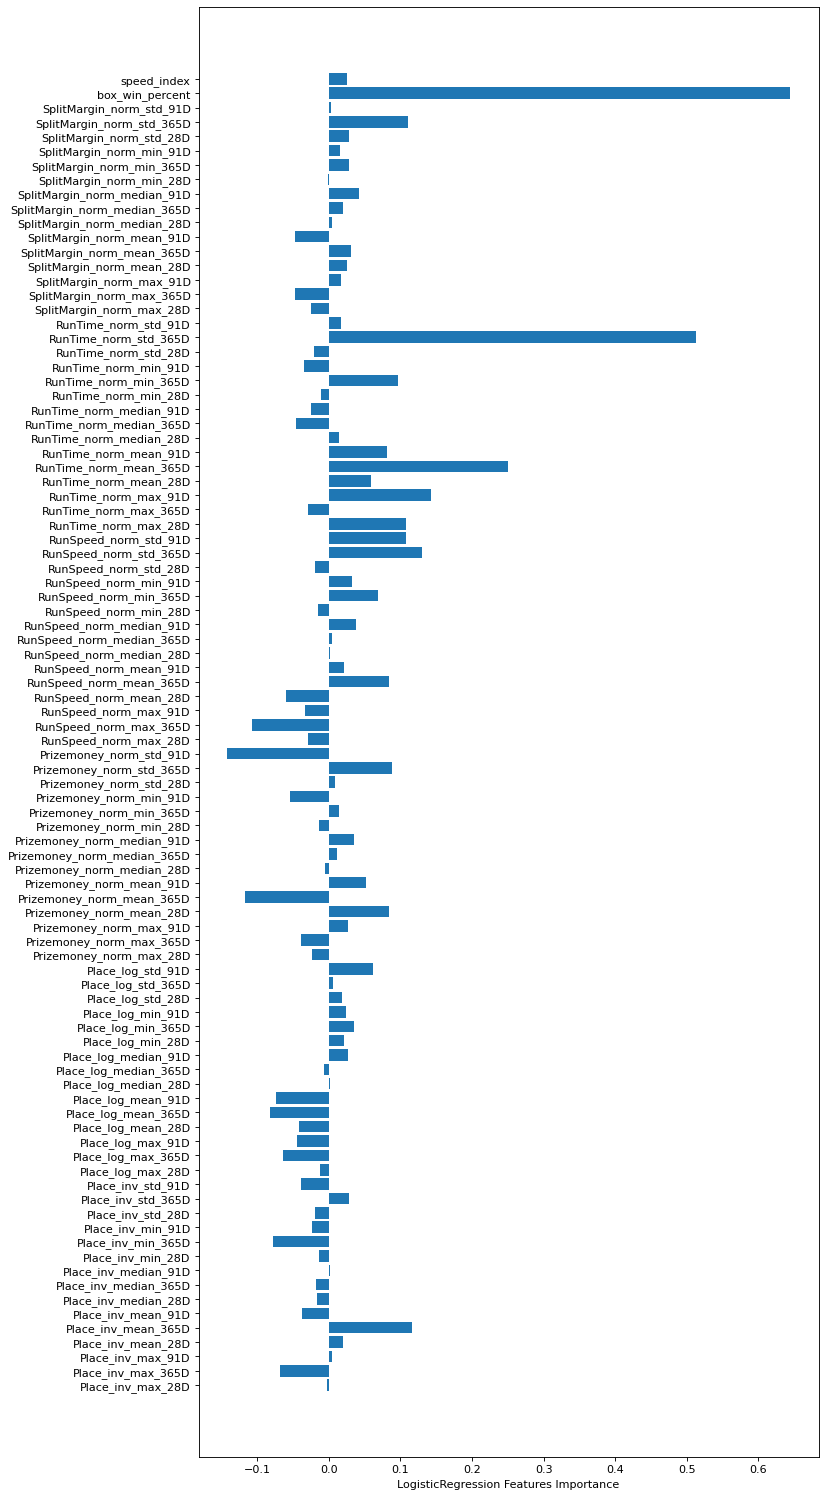

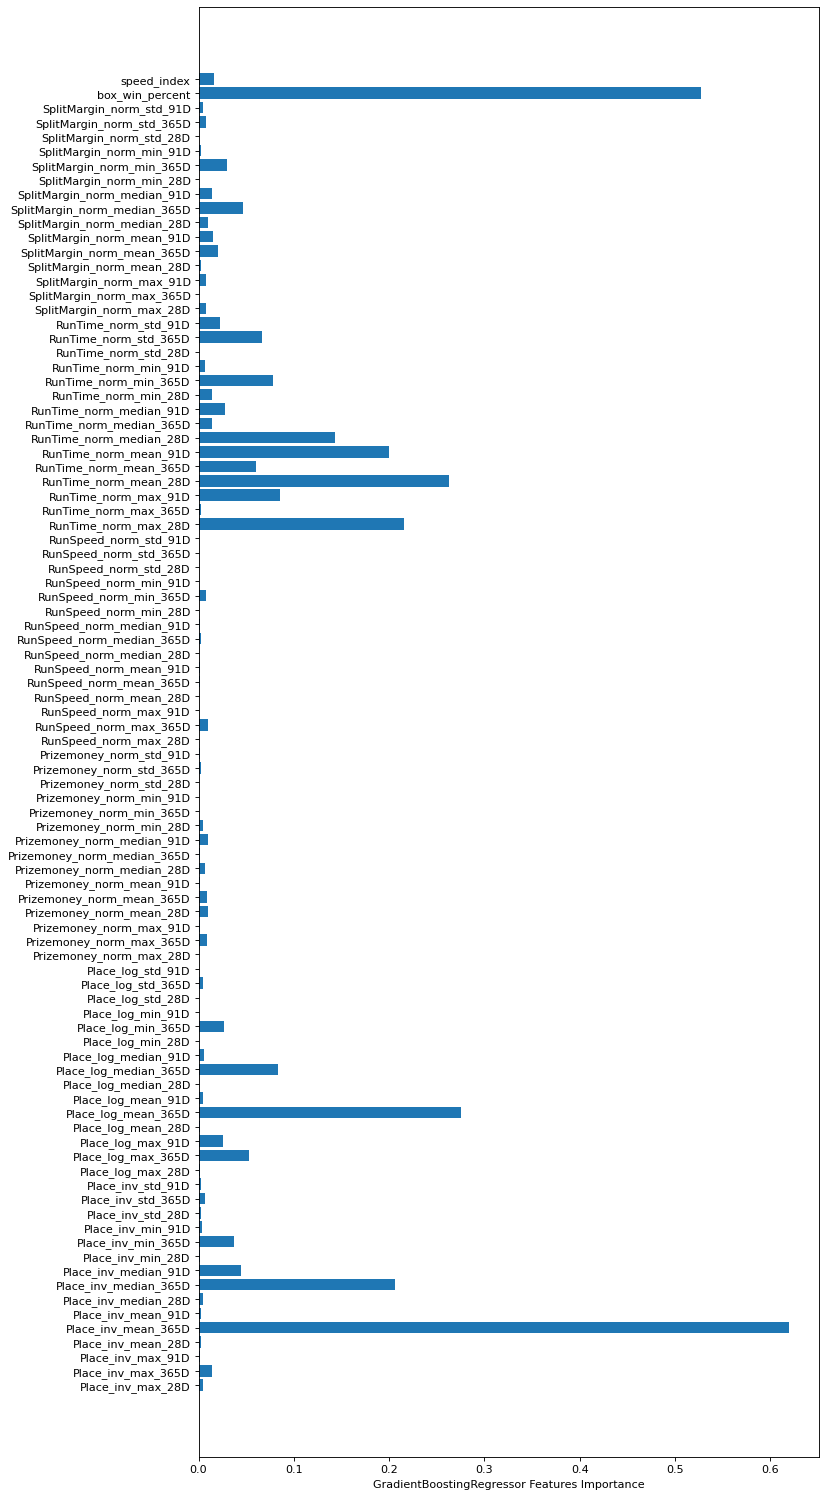

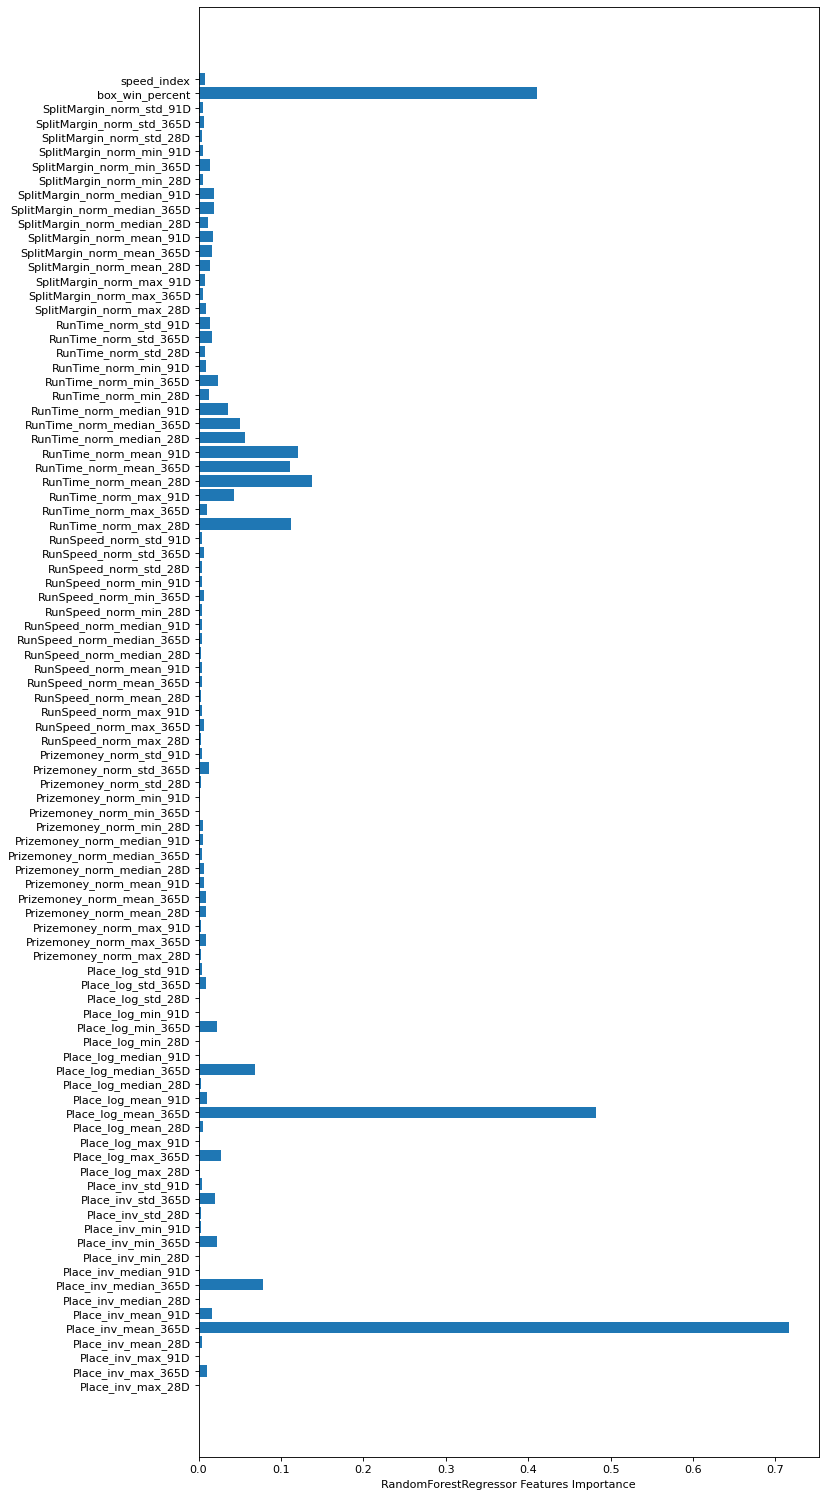

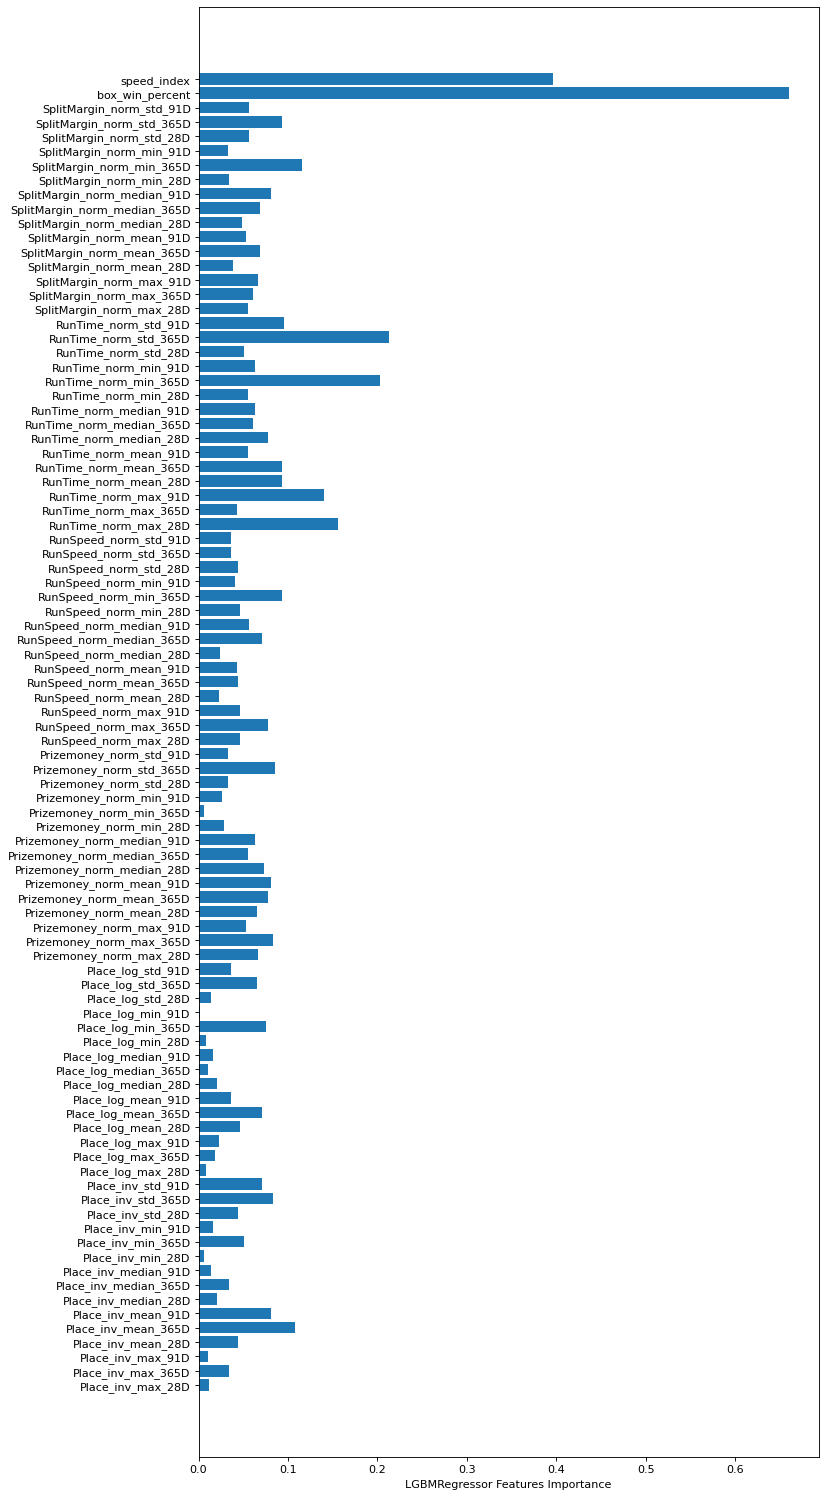

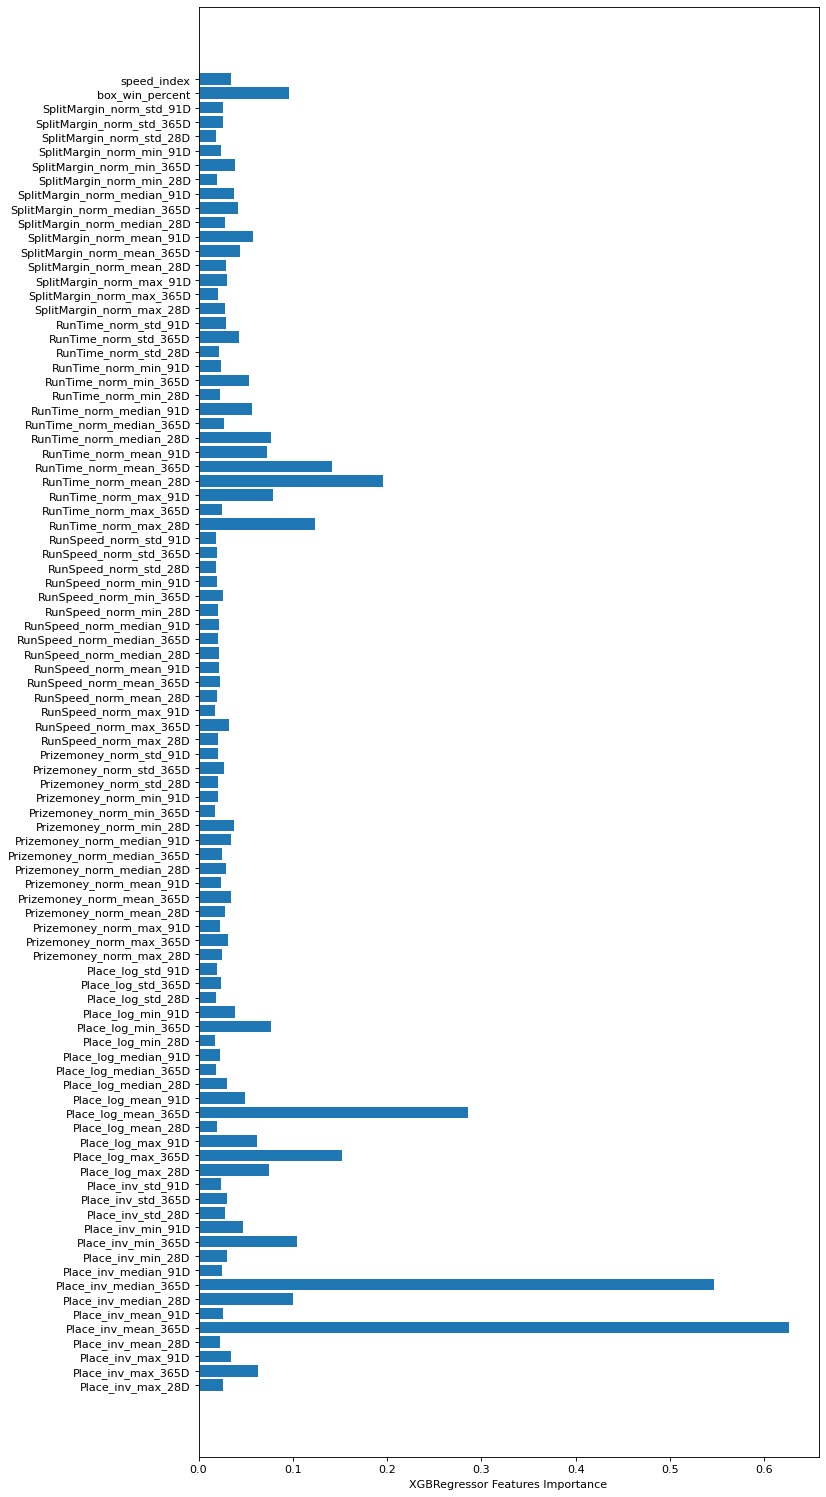

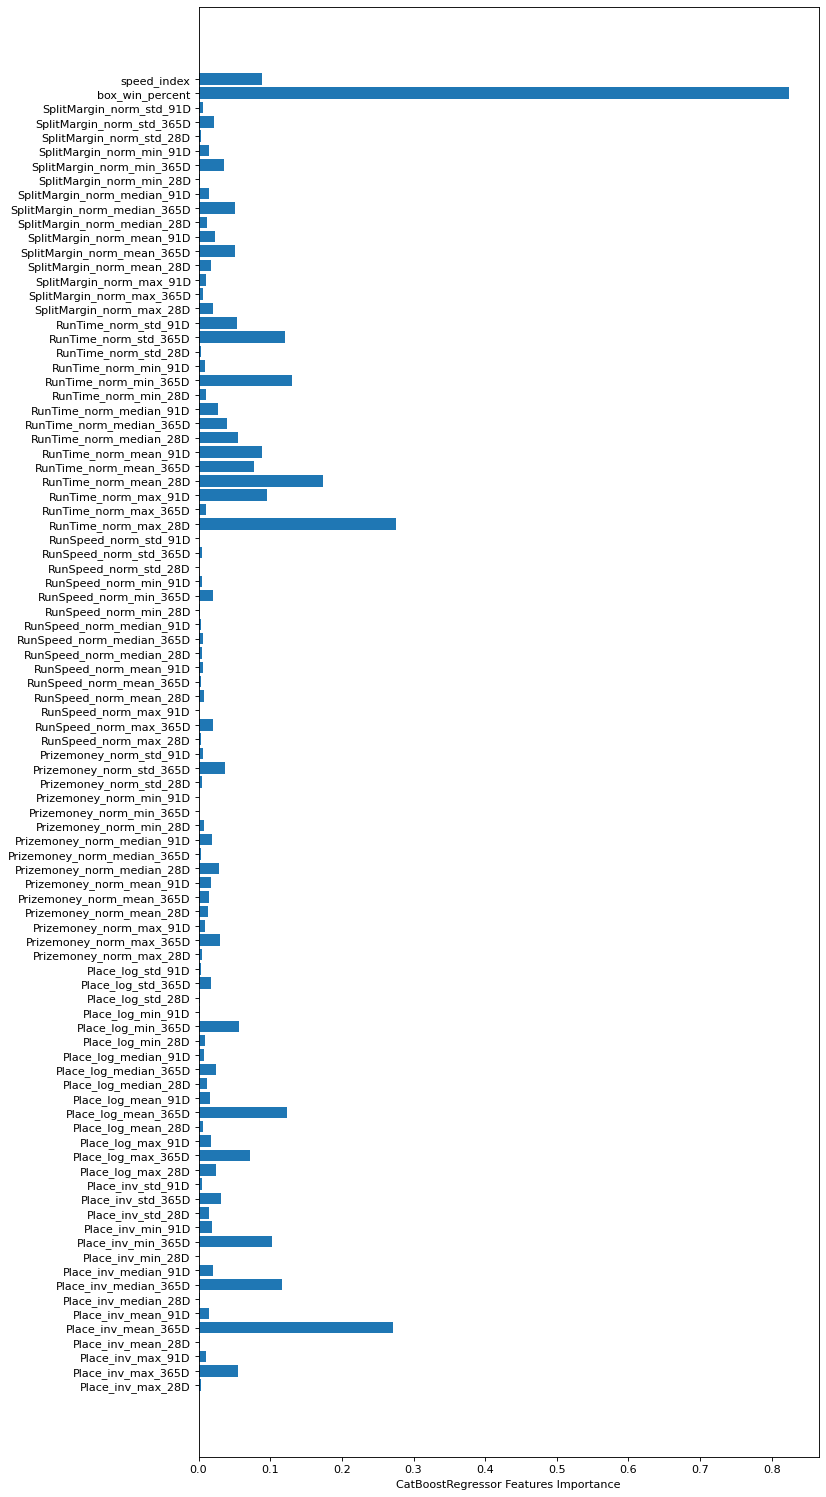

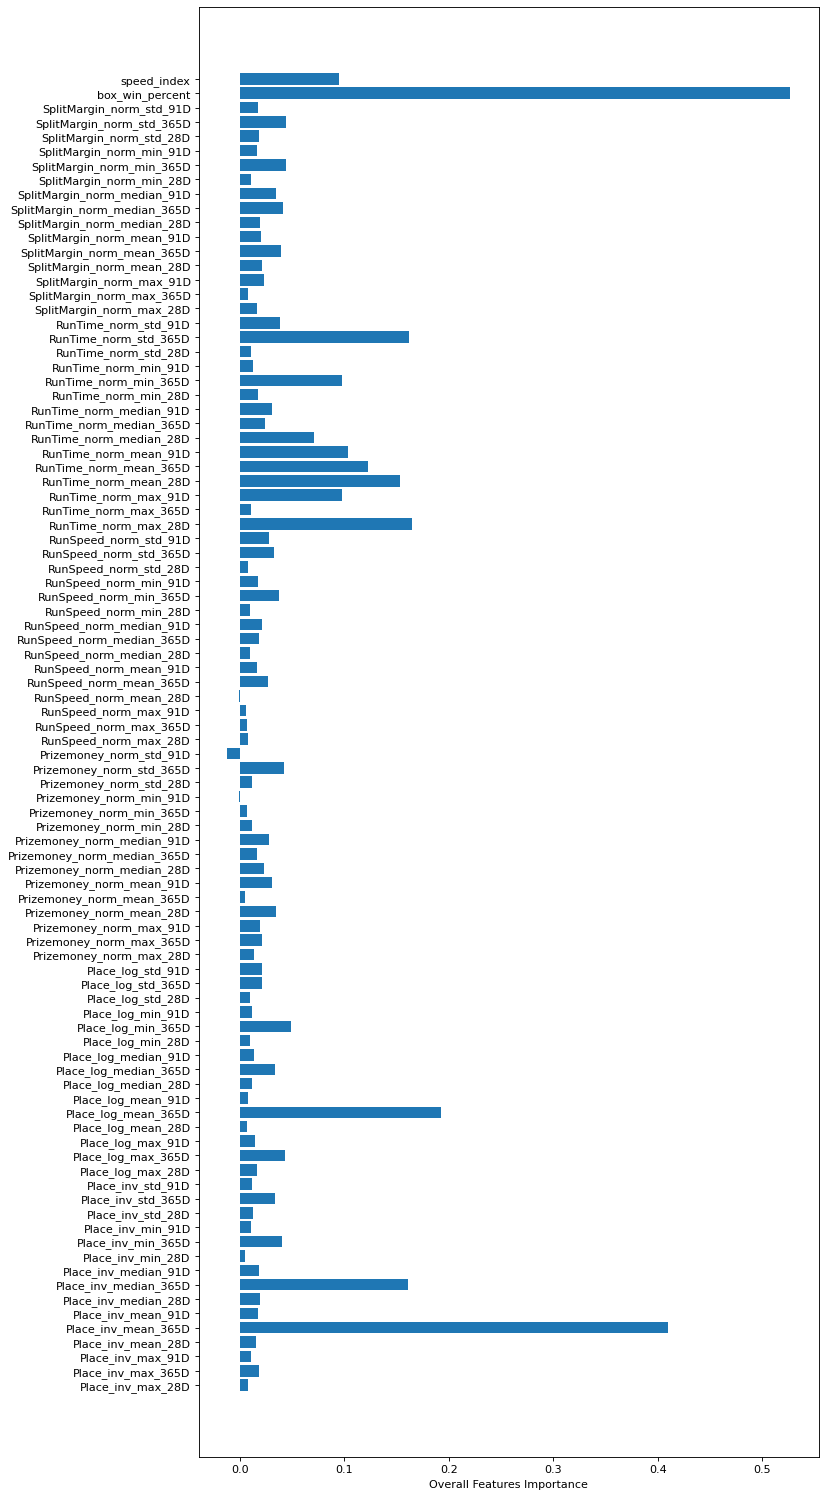

In [15]:
total_feature_importances = []

# Individual models feature importance
for key, model in models.items():
    figure(figsize=(10, 24), dpi=80)
    if isinstance(model, LogisticRegression):
        feature_importance = model.coef_[0]
    else:
        feature_importance = model.feature_importances_
    
    feature_importance = normalize(feature_importance[:,np.newaxis], axis=0).ravel()
    total_feature_importances.append(feature_importance)
    pyplot.barh(feature_cols, feature_importance)
    pyplot.xlabel(f'{key} Features Importance')
    pyplot.show()

# Overall feature importance
avg_feature_importances = np.asarray(total_feature_importances).mean(axis=0)
figure(figsize=(10, 24), dpi=80)
pyplot.barh(feature_cols, avg_feature_importances)
pyplot.xlabel('Overall Features Importance')
pyplot.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Activation, Dropout, Input, Dense, Lambda, Masking, Reshape
import tensorflow.keras.backend as K
from tensorflow import keras

inputs = Input(shape=(train_x.shape[1],))
layer1 = Dense(1024, activation="relu")(inputs)
layer2 = Dense(1024, activation="tanh", kernel_initializer='glorot_uniform')(layer1)
layer3 = Dense(1024, activation="linear")(layer2)
outputs = Dense(1, activation="sigmoid")(layer3)
model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adamax()
loss      = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001, from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy', 'binary_crossentropy'])
model.summary()

model.fit(x=train_x, y=train_y, validation_data=(test_x, test_y), epochs=6)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 92)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              95232     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 2,195,457
Trainable params: 2,195,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
19698/19698 [==============================] - 75s 4ms/step - loss: 0.3857 - binary_accuracy: 0.8593 - bina

In [17]:
test_data['prob_Tensorflow'] = model.predict(test_x)
test_data['prob_Tensorflow'] = test_data.groupby('FastTrack_RaceId')['prob_Tensorflow'].apply(lambda x: x / sum(x))
predicted_winners = test_data.groupby('FastTrack_RaceId')['prob_Tensorflow'].apply(lambda x: x == max(x))
print('Model {} predicts the winner in {:.2%} of races'.format('Tensorflow',
    len(test_data[(predicted_winners == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
    ))

Model Tensorflow predicts the winner in 33.18% of races
